In [0]:
## imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import json
from google.colab import files

import keras
from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Conv2DTranspose, Reshape, Conv2D, Flatten
from keras.models import Model, Sequential
from keras.datasets import mnist

In [2]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 3 

input_img = keras.Input(shape=img_shape)

encoder = Conv2D(32, 3, padding="same", activation="relu")(input_img)
encoder = Conv2D(64, 3, padding="same", strides=(2,2), activation="relu")(encoder)
encoder = Conv2D(64, 3, padding="same", activation="relu")(encoder)
encoder = Conv2D(64, 3, padding="same", activation="relu")(encoder)


shape_before_flattening = K.int_shape(encoder)

encoder = Flatten()(encoder)
encoder = Dense(32, activation="relu")(encoder)

print(encoder.shape)
z_mean = Dense(latent_dim)(encoder)
z_log_var = Dense(latent_dim)(encoder)

(?, 32)


In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

In [0]:
decoder_input = Input(K.int_shape(z)[1:])
decoder  = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
decoder  = Reshape(shape_before_flattening[1:])(decoder)
decoder  = Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(decoder)
decoder = Conv2D(1, 3, padding='same', activation='sigmoid')(decoder)
decoder = Model(decoder_input, decoder)
z_decoded = decoder(z)

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [6]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

11493376/11490434 [==============================] - 4s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 7744/60000 [==>...........................] - ETA: 5:41 - loss: 3181.0030

31376/60000 [==============>...............] - ETA: 3:09 - loss: 785.2611

60000/60000 [==============================] - 420s 7ms/step - loss: 410.7280 - val_loss: 0.1808


Epoch 2/10
41648/60000 [===================>..........] - ETA: 2:01 - loss: 0.1819

60000/60000 [==============================] - 411s 7ms/step - loss: 0.1820 - val_loss: 0.1818
Epoch 3/10
 1472/60000 [..............................] - ETA: 6:27 - loss: 0.1825

23808/60000 [==========>...................] - ETA: 3:54 - loss: 0.1899

60000/60000 [==============================] - 412s 7ms/step - loss: 0.1906 - val_loss: 0.1845


Epoch 4/10
24064/60000 [===========>..................] - ETA: 3:58 - loss: 0.1812

50464/60000 [========================>.....] - ETA: 1:02 - loss: 0.1802

60000/60000 [==============================] - 411s 7ms/step - loss: 0.1798 - val_loss: 0.1775
Epoch 5/10
 4960/60000 [=>............................] - ETA: 5:55 - loss: 0.1772

27552/60000 [============>.................] - ETA: 3:27 - loss: 0.1765

58048/60000 [============================>.] - ETA: 12s - loss: 0.1766

60000/60000 [==============================] - 404s 7ms/step - loss: 0.1766 - val_loss: 0.1765
Epoch 6/10
 8000/60000 [===>..........................] - ETA: 5:36 - loss: 0.1766

29856/60000 [=============>................] - ETA: 3:15 - loss: 0.1760

54704/60000 [==========================>...] - ETA: 34s - loss: 0.1756

60000/60000 [==============================] - 405s 7ms/step - loss: 0.1755 - val_loss: 0.1754
Epoch 7/10
 6416/60000 [==>...........................] - ETA: 5:41 - loss: 0.1764

26880/60000 [============>.................] - ETA: 3:31 - loss: 0.1760

47680/60000 [======================>.......] - ETA: 1:18 - loss: 0.1757

60000/60000 [==============================] - 400s 7ms/step - loss: 0.1755 - val_loss: 0.1722
Epoch 8/10
 3856/60000 [>.............................] - ETA: 6:02 - loss: 0.1759

26080/60000 [============>.................] - ETA: 3:38 - loss: 0.1753

47472/60000 [======================>.......] - ETA: 1:20 - loss: 0.1758

60000/60000 [==============================] - 402s 7ms/step - loss: 0.1759 - val_loss: 0.1766
Epoch 9/10
 3408/60000 [>.............................] - ETA: 6:00 - loss: 0.1826

28400/60000 [=============>................] - ETA: 3:23 - loss: 0.1761

49728/60000 [=======================>......] - ETA: 1:06 - loss: 0.1759

60000/60000 [==============================] - 405s 7ms/step - loss: 0.1761 - val_loss: 0.1793
Epoch 10/10
 4688/60000 [=>............................] - ETA: 5:56 - loss: 0.1768

25344/60000 [===========>..................] - ETA: 3:41 - loss: 0.1754

46608/60000 [======================>.......] - ETA: 1:25 - loss: 0.1764

60000/60000 [==============================] - 401s 7ms/step - loss: 0.1767 - val_loss: 0.1744


In [0]:
vae.save('./vae_tutorial_model.h5')
vae_tutorial_model_json = vae.to_json()
with open('./var_tutorial_model_string.json', 'w') as outfile:
  json.dump(vae_tutorial_model_json, outfile)

In [0]:
files.download('vae_tutorial_model.h5')
files.download('var_tutorial_model_string.json')

In [0]:
import matplotlib.pyplot as plt

ValueError: ignored

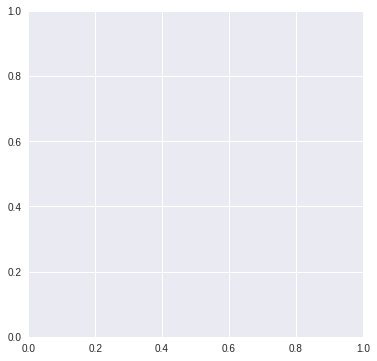

In [14]:
x_test_encoded = vae.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()